In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.inspection import PartialDependenceDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 랜덤 포레스트로 분석할 데이터 불러오기
df1 = pd.read_csv("../01_data/02_processed/production/X_train_nonlinear.csv")
df2 = pd.read_csv("../01_data/02_processed/production/y_train.csv")
df3 = pd.read_csv("../01_data/02_processed/production/X_test_nonlinear.csv")
df4 = pd.read_csv("../01_data/02_processed/production/y_test.csv")

# sklearn 입력 형식에 맞게 target을 1차원 Series로 변환
df2 = df2.squeeze()
df4 = df4.squeeze()
df4.head()

0     95
1    105
2     85
3    140
4     31
Name: Delivery_Time, dtype: int64

In [4]:
# 랜덤 포레스트 모델 생성 (OBB 검증, 트리 개수 300개)
rf_oob = RandomForestRegressor(n_estimators = 300, random_state = 42, n_jobs = -1, oob_score = True, bootstrap = True)

# 데이터 학습
rf_oob.fit(df1, df2)

# OOB 샘플에 대한 평균 예측값 추출
oob_pred = rf_oob.oob_prediction_

# OOB 예측값과 실제값을 비교하여 RMSE 계산
oob_rmse = np.sqrt(mean_squared_error(df2, oob_pred))
print("OOB_RMSE:", oob_rmse)

OOB_RMSE: 22.86599650467113


In [5]:
# 랜덤 포레스트 모델 생성 (OBB 검증, 트리 개수 500개)
rf_oob = RandomForestRegressor(n_estimators = 500, random_state = 42, n_jobs = -1, oob_score = True, bootstrap = True)
rf_oob.fit(df1, df2)
oob_pred = rf_oob.oob_prediction_
oob_rmse = np.sqrt(mean_squared_error(df2, oob_pred))
print("OOB_RMSE:", oob_rmse)

OOB_RMSE: 22.852395005953287


In [6]:
# 랜덤 포레스트 모델 생성 (CV 검증, 트리 개수 300개)
rf_cv = RandomForestRegressor(n_estimators = 300, random_state = 42, n_jobs = -1)

# 데이터 학습, MSE 계산
cv_mse = cross_val_score(rf_cv, df1, df2, cv = 5, scoring = "neg_mean_squared_error", n_jobs = -1)

# 음수 MSE를 양수로 변환 후 RMSE 계산
cv_rmse = np.sqrt(-cv_mse)
print("CV_RMSE:", cv_rmse.mean())

CV_RMSE: 22.91082475365736


In [7]:
# 랜덤 포레스트 모델 생성 (CV 검증, 트리 개수 500개)
rf_cv = RandomForestRegressor(n_estimators = 500, random_state = 42, n_jobs = -1)
cv_mse = cross_val_score(rf_cv, df1, df2, cv = 5, scoring = "neg_mean_squared_error", n_jobs = -1)
cv_rmse = np.sqrt(-cv_mse)
print("CV_RMSE:", cv_rmse.mean())

CV_RMSE: 22.89660275928778


In [8]:
# 최적의 파라미터를 사용한 랜덤 포레스트 모델 생성
rf_final = RandomForestRegressor(n_estimators = 550, max_depth = 12, max_features = None, min_samples_leaf = 2,         
    min_samples_split = 6,random_state = 42, n_jobs = -1, oob_score = True, bootstrap = True)

# 데이터 학습
rf_final.fit(df1, df2)

# 데이터 예측
y_pred = rf_final.predict(df3)

# RMSE와 MAE 계산
test_rmse = np.sqrt(mean_squared_error(df4, y_pred))
test_mae = mean_absolute_error(df4, y_pred)
print("Test_RMSE:", test_rmse)
print("Test_MAE:", test_mae)

Test_RMSE: 22.098968449776326
Test_MAE: 17.096838197413508


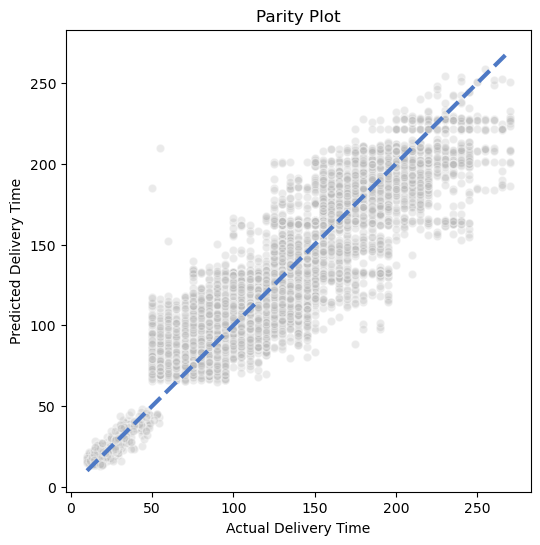

In [9]:
# 그래프 크기 설정
plt.figure(figsize = (6,6))

# 실제값과 예측값 산점도
plt.scatter(df4, y_pred, alpha=0.3, color = "#BBBBBB", edgecolors = "white")

# 기준선 범위 계산
min_val = min(df4.min(), y_pred.min())
max_val = max(df4.max(), y_pred.max())

# 기준선 추가
plt.plot([min_val, max_val], [min_val, max_val], color = "#4E79C5", linestyle = "--", linewidth = 3 )

# 그래프 라벨 및 제목 설정
plt.xlabel("Actual Delivery Time")
plt.ylabel("Predicted Delivery Time")
plt.title("Parity Plot")
plt.savefig("../04_results/random_forest/fig1.png", dpi = 300, bbox_inches = "tight")
plt.show()

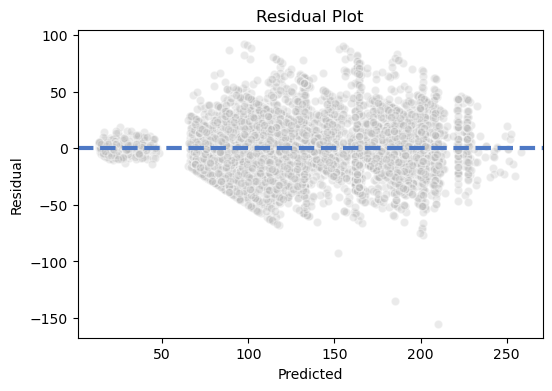

In [10]:
# 잔차 계산
residuals = df4 - y_pred

# 그래프 크기 설정
plt.figure(figsize = (6,4))

# 예측값과 잔차 산점도
plt.scatter(y_pred, residuals, alpha=0.3, color = "#BBBBBB", edgecolors = "white")

# 기준선 추가
plt.axhline(0, color = "#4E79C5", linestyle = "--", linewidth = 3)

# 그래프 라벨 및 제목 설정
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.savefig("../04_results/random_forest/fig2.png", dpi = 300, bbox_inches = "tight")
plt.show()

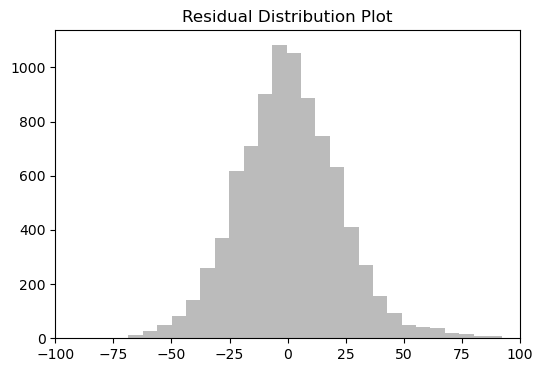

In [11]:
# 그래프 크기 설정
plt.figure(figsize = (6,4))

# 잔차 분포 히스토그램
plt.hist(residuals, bins = 40, color = "#BBBBBB")

# 중앙 구간 확대
plt.xlim(-100, 100)

# 그래프 라벨 및 제목 설정
plt.title("Residual Distribution Plot")
plt.savefig("../04_results/random_forest/fig3.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [12]:
# 학습된 랜덤 포레스트 모델의 변수 중요도 추출
importances = rf_final.feature_importances_

# 학습에 사용된 입력 변수 이름 불러오기
feature_names = df1.columns 

# 변수 이름과 중요도를 합쳐서 데이터 프레임을 만들고 중요도 기준으로 내림차순 정렬
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

# 상위 15개만 선택
top15 = feat_imp.head(15)
print(top15)

               feature  importance
13    Category_Grocery    0.278192
1         Agent_Rating    0.185248
25       Weather_score    0.165848
24       Traffic_score    0.138495
2             Distance    0.098801
0            Agent_Age    0.087652
4      Vehicle_scooter    0.019637
5          Vehicle_van    0.007693
6   Area_Metropolitian    0.005109
8      Area_Semi_Urban    0.004609
3     Pickup_Wait_Time    0.001639
11  Category_Cosmetics    0.000667
20   Category_Skincare    0.000627
9     Category_Apparel    0.000546
15    Category_Jewelry    0.000507


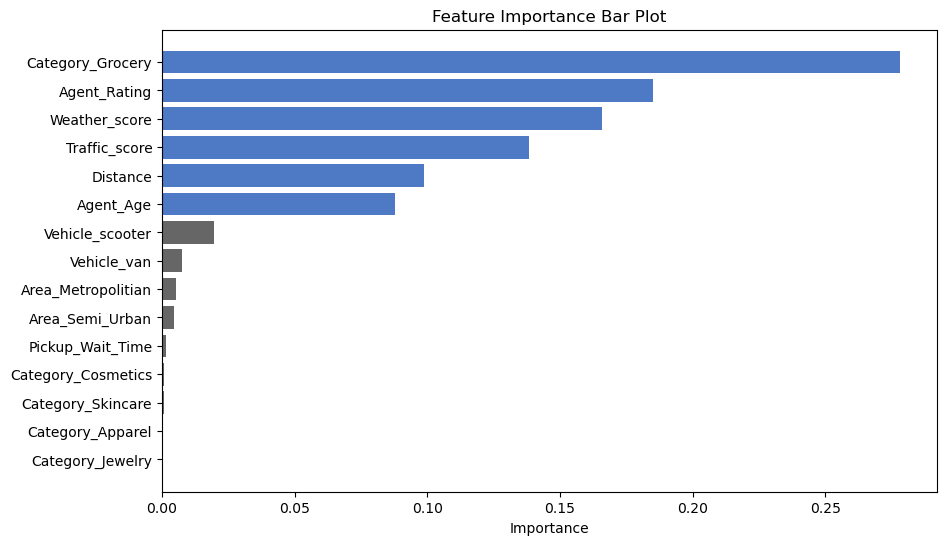

In [13]:
# 그래프 크기 설정
plt.figure(figsize = (10,6))

# 상위 6개 중요도 변수를 강조하기 위한 색상 배열 생성
colors = ["#4E79C5" if i < 6 else "#666666" for i in range(len(top15))]

# 가로 막대 그래프 생성 (x축 = 중요도, y축 = 변수 이름)
plt.barh(top15["feature"], top15["importance"], color = colors)

# y축 뒤집기
plt.gca().invert_yaxis()

# 그래프 라벨 및 제목 설정
plt.title("Feature Importance Bar Plot")
plt.xlabel("Importance")
plt.savefig("../04_results/random_forest/fig4.png", dpi = 300, bbox_inches = "tight")
plt.show()

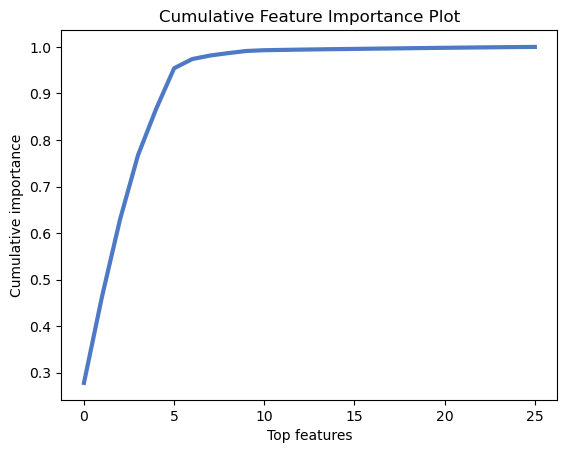

In [14]:
# 학습된 랜덤 포레스트 모델의 변수 중요도 추출
imp = rf_final.feature_importances_

# 중요도를 내림차순 정렬
sorted_imp = np.sort(imp)[::-1]

# 누적 합 계산
cum_imp = np.cumsum(sorted_imp)

# 누적 중요도 곡선 시각화 / y축 = 누적 변수 중요도 / x축 = 상위 변수 개수 (자동 생성되는 인덱스)
plt.plot(cum_imp, color = "#4E79C5", linewidth = 3)  

# 그래프 라벨 및 제목 설정
plt.title("Cumulative Feature Importance Plot")
plt.ylabel("Cumulative importance")
plt.xlabel("Top features")
plt.savefig("../04_results/random_forest/fig5.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [15]:
# 모델이 학습한 데이터의 컬럼 이름 리스트 만들기
cols = list(df1.columns)

# 학습된 랜덤 포레스트 모델의 변수 중요도 추출
imp = rf_final.feature_importances_

# Human 그룹 인덱스 찾기
idx_human = [cols.index("Agent_Age"), cols.index("Agent_Rating")]

# Environment 그룹 인덱스 찾기
idx_environment = [cols.index("Weather_score"), cols.index("Traffic_score"), cols.index("Distance")]

# Operational 그룹 인덱스 찾기
# 첫번째 반복 예시 
# i = 0, c = "Agent_Age" -> 조건 검사 -> Vehicle_, Area_, Category_로 시작하는지 또는 Pickup_Wait_Time인지 확인  
# 조건에 맞으면 i = 0을 저장 조건에 맞지 않으면 i = 0을 저장하지 않음
idx_operational = [i for i,c in enumerate(cols) if c.startswith("Vehicle_") or c.startswith("Area_") or c.startswith("Category_") or c == "Pickup_Wait_Time"]

# 그룹 중요도 합산
group_importance = {"Human": imp[idx_human].sum(), "Environment": imp[idx_environment].sum(), "Operational": imp[idx_operational].sum()}

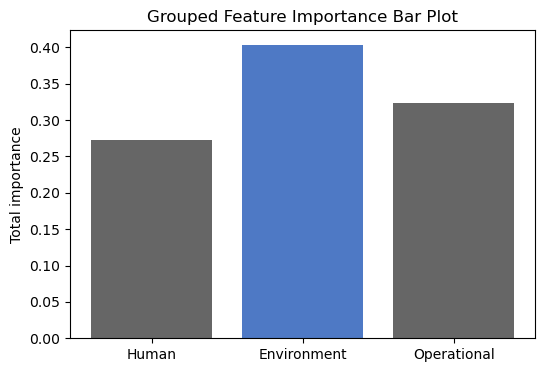

In [16]:
# 그룹 이름과 중요도 분리
names = list(group_importance.keys())
values = list(group_importance.values())

# 중요도가 제일 큰 값 찾기
max_idx = np.argmax(values)

# 색상 배열 만들기
colors = ["#666666"] * len(values)   
colors[max_idx] = "#4E79C5"          

# 그래프 크기 설정
plt.figure(figsize = (6,4))
# 막대 그래프 생성
plt.bar(names, values, color = colors)

# 그래프 라벨 및 제목 설정
plt.ylabel("Total importance")
plt.title("Grouped Feature Importance Bar Plot")
plt.savefig("../04_results/random_forest/fig6.png", dpi = 300, bbox_inches = "tight")
plt.show()

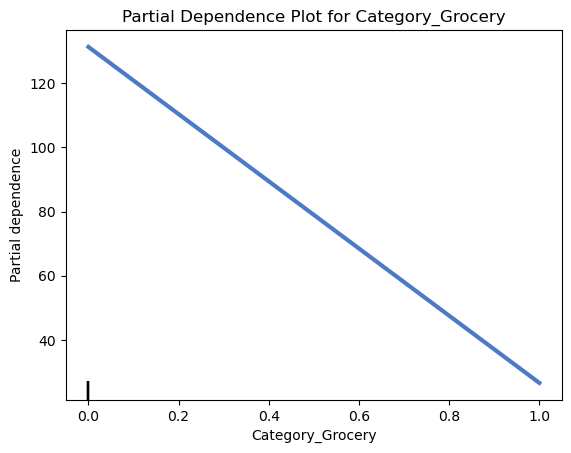

In [17]:
# Category_Grocery 변수의 부분 의존성 그래프 생성
# 다른 변수 값은 그대로 둔 상태에서 Category_Grocery 값만 강제로 바꿔 모델의 평균 예측 배송시간이 어떻게 변하는지 계산함
# 모든 행을 Grocery 아님으로 가정했을 때 평균 예측 배송시간과 모든 행을 Grocery로 가정했을 때 평균 예측 배송시간
# 이 두 값을 비교해서 그래프로 표현함
PartialDependenceDisplay.from_estimator(rf_final, df1, ["Category_Grocery"], kind = "average", 
                                        grid_resolution = 100, line_kw = {"color": "#4E79C5", "linewidth": 3})

# 그래프 라벨 및 제목 설정
plt.title("Partial Dependence Plot for Category_Grocery")
plt.savefig("../04_results/random_forest/fig7_1.png", dpi = 300, bbox_inches = "tight")

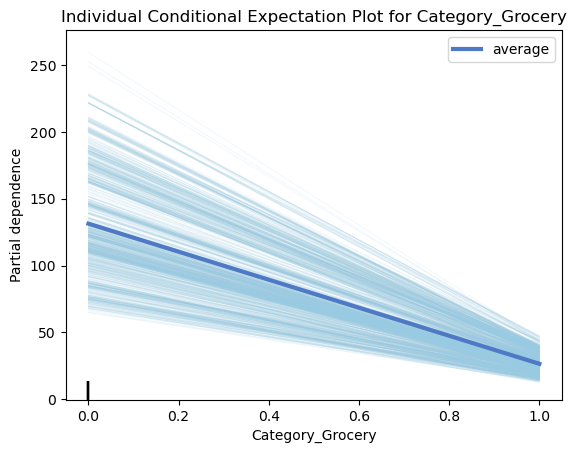

In [18]:
PartialDependenceDisplay.from_estimator(rf_final, df1, ["Category_Grocery"], kind = "both", 
                                        subsample = 1000, grid_resolution = 100, 
                                        ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
                                        pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"})

plt.title("Individual Conditional Expectation Plot for Category_Grocery")
plt.savefig("../04_results/random_forest/fig7_2.png", dpi = 300, bbox_inches = "tight")
plt.show()

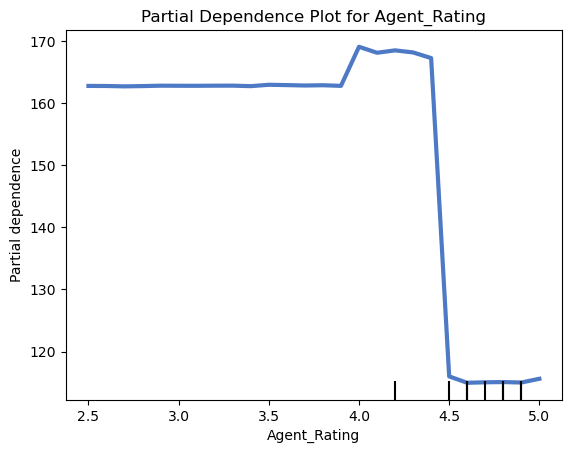

In [19]:
# Agent_Age 변수의 부분 의존성 그래프 생성
PartialDependenceDisplay.from_estimator(rf_final, df1, ["Agent_Rating"], kind = "average", 
                                        grid_resolution = 100, line_kw = {"color": "#4E79C5", "linewidth": 3})
# 그래프 라벨 및 제목 설정
plt.title("Partial Dependence Plot for Agent_Rating")
plt.savefig("../04_results/random_forest/fig8_1.png", dpi = 300, bbox_inches = "tight")
plt.show()

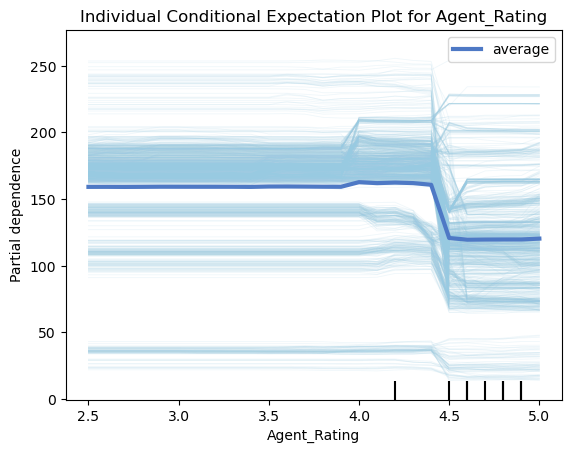

In [20]:
PartialDependenceDisplay.from_estimator(rf_final, df1, ["Agent_Rating"], kind = "both", 
                                        subsample = 1000, grid_resolution = 100, 
                                        ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
                                        pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"})

plt.title("Individual Conditional Expectation Plot for Agent_Rating")
plt.savefig("../04_results/random_forest/fig8_2.png", dpi = 300, bbox_inches = "tight")
plt.show()

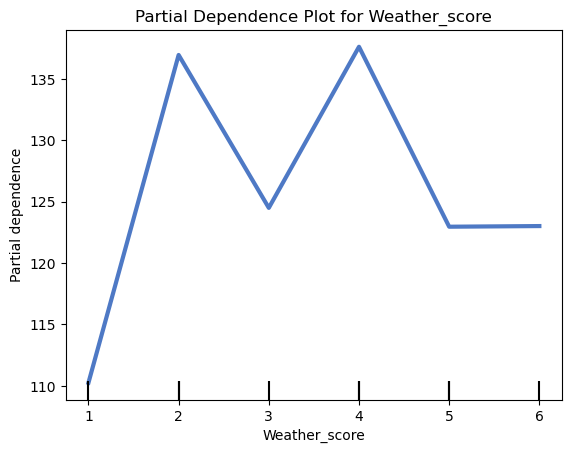

In [21]:
# Weather_score 변수를 실수형으로 변환
df1["Weather_score"] = df1["Weather_score"].astype(float)

# Weather_score 변수의 부분 의존성 그래프 생성
PartialDependenceDisplay.from_estimator(rf_final, df1, ["Weather_score"], kind = "average", 
                                        grid_resolution = 100, line_kw = {"color": "#4E79C5", "linewidth": 3})
# 그래프 라벨 및 제목 설정
plt.title("Partial Dependence Plot for Weather_score")
plt.savefig("../04_results/random_forest/fig9_1.png", dpi = 300, bbox_inches = "tight")
plt.show()

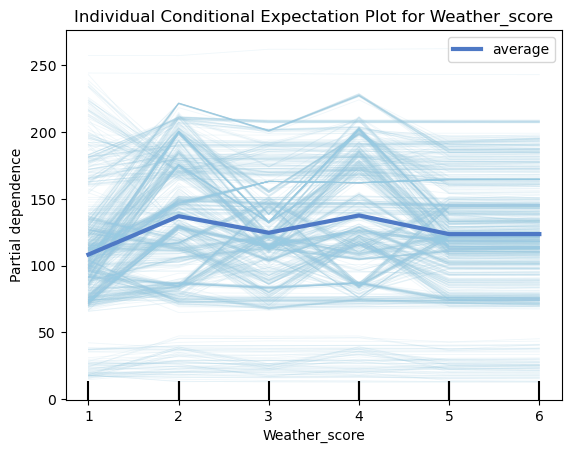

In [22]:
# Weather_score 변수를 실수형으로 변환
df1["Weather_score"] = df1["Weather_score"].astype(float)

PartialDependenceDisplay.from_estimator(rf_final, df1, ["Weather_score"], kind = "both", 
                                        subsample = 1000, grid_resolution = 100, 
                                        ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
                                        pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"})

plt.title("Individual Conditional Expectation Plot for Weather_score")
plt.savefig("../04_results/random_forest/fig9_2.png", dpi = 300, bbox_inches = "tight")
plt.show()

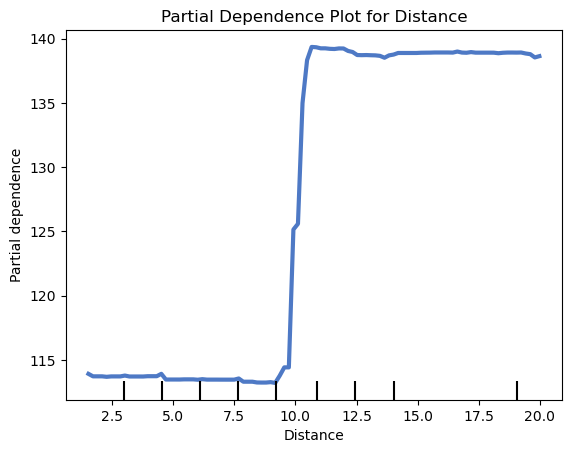

In [23]:
# Distance 변수의 부분 의존성 그래프 생성
PartialDependenceDisplay.from_estimator(rf_final, df1, ["Distance"], kind = "average", 
                                        grid_resolution = 100, line_kw = {"color": "#4E79C5", "linewidth": 3})
# 그래프 라벨 및 제목 설정
plt.title("Partial Dependence Plot for Distance")
plt.savefig("../04_results/random_forest/fig10_1.png", dpi = 300, bbox_inches = "tight")
plt.show()

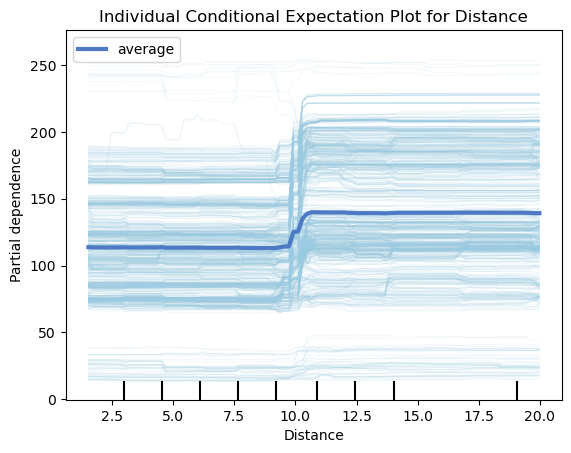

In [24]:
PartialDependenceDisplay.from_estimator(rf_final, df1, ["Distance"], kind = "both", 
                                        subsample = 1000, grid_resolution = 100, 
                                        ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
                                        pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"})

plt.title("Individual Conditional Expectation Plot for Distance")
plt.savefig("../04_results/random_forest/fig10_2.png", dpi = 300, bbox_inches = "tight")
plt.show()

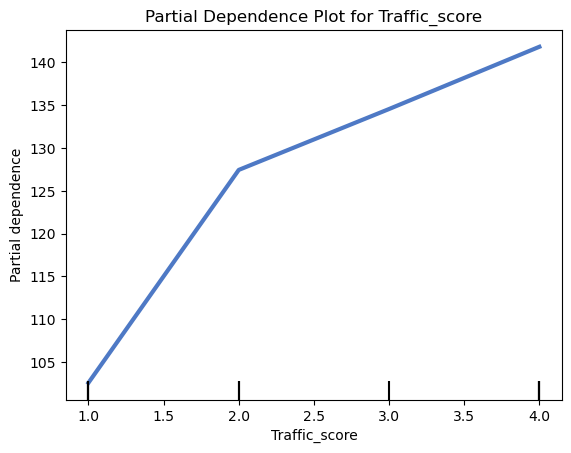

In [25]:
# Traffic_score 변수를 실수형으로 변환
df1["Traffic_score"] = df1["Traffic_score"].astype(float)

# Traffic_score 변수의 부분 의존성 그래프 생성
PartialDependenceDisplay.from_estimator(rf_final, df1, ["Traffic_score"], kind = "average", 
                                        grid_resolution = 100, line_kw = {"color": "#4E79C5", "linewidth": 3})
# 그래프 라벨 및 제목 설정
plt.title("Partial Dependence Plot for Traffic_score")
plt.savefig("../04_results/random_forest/fig11_1.png", dpi = 300, bbox_inches = "tight")
plt.show()

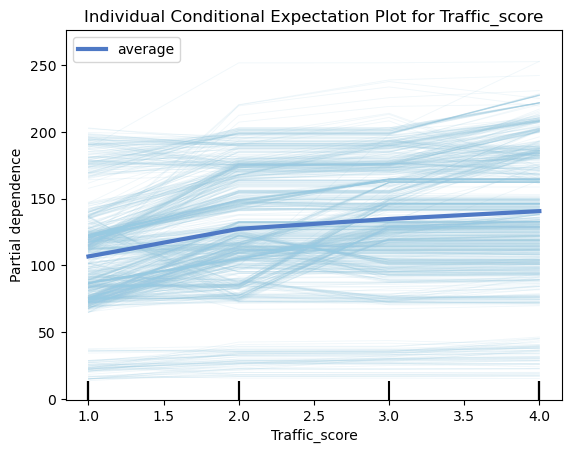

In [26]:
# Traffic_score 변수를 실수형으로 변환
df1["Traffic_score"] = df1["Traffic_score"].astype(float)

PartialDependenceDisplay.from_estimator(rf_final, df1, ["Traffic_score"], kind = "both", 
                                        subsample = 1000, grid_resolution = 100, 
                                        ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
                                        pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"})

plt.title("Individual Conditional Expectation Plot for Traffic_score")
plt.savefig("../04_results/random_forest/fig11_2.png", dpi = 300, bbox_inches = "tight")
plt.show()

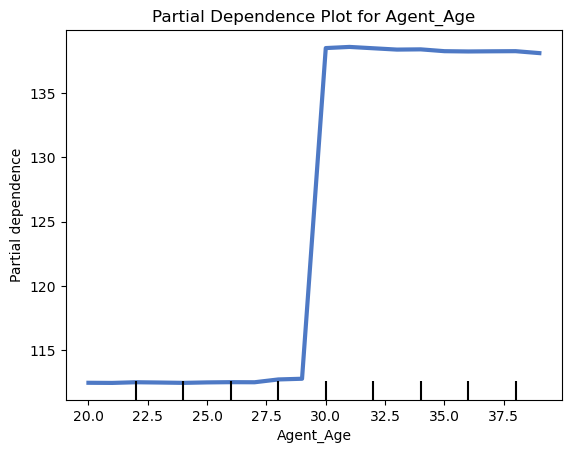

In [27]:
# Agent_Age 변수를 실수형으로 변환
df1["Agent_Age"] = df1["Agent_Age"].astype(float)

# Agent_Age 변수의 부분 의존성 그래프 생성
PartialDependenceDisplay.from_estimator(rf_final, df1, ["Agent_Age"], kind = "average", 
                                        grid_resolution = 100, line_kw = {"color": "#4E79C5", "linewidth": 3})
# 그래프 라벨 및 제목 설정
plt.title("Partial Dependence Plot for Agent_Age")
plt.savefig("../04_results/random_forest/fig12_1.png", dpi = 300, bbox_inches = "tight")
plt.show()

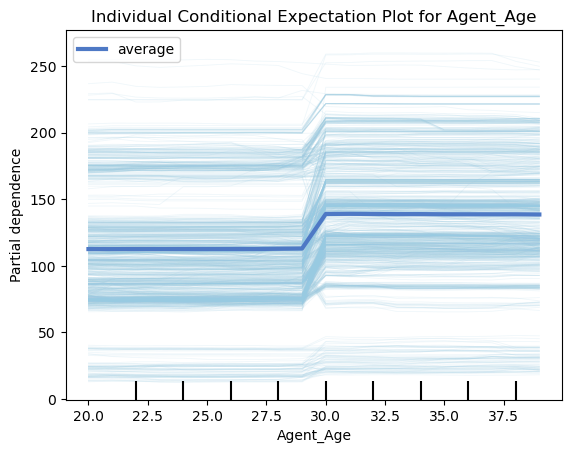

In [28]:
# Agent_Age 변수를 실수형으로 변환
df1["Agent_Age"] = df1["Agent_Age"].astype(float)

PartialDependenceDisplay.from_estimator(rf_final, df1, ["Agent_Age"], kind = "both", 
                                        subsample = 1000, grid_resolution = 100, 
                                        ice_lines_kw = {"color": "#98CAE1", "alpha": 0.15, "linewidth": 0.6},
                                        pd_line_kw = {"color": "#4E79C5", "linewidth": 3, "linestyle": "-"})

plt.title("Individual Conditional Expectation Plot for Agent_Age")
plt.savefig("../04_results/random_forest/fig12_2.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [29]:
# 모델에게 입력한 데이터 복사
worst_df = df3.copy()

# 실제 배송시간 붙이기
worst_df["Actual"] = df4.values

# 모델 예측값 붙이기
worst_df["Predicted"] = y_pred

# 절대 오차 붙이기
worst_df["Error"] = abs(df4.values - y_pred)

# 오차를 내림차순으로 정렬
worst_df = worst_df.sort_values("Error", ascending = False)
worst_df.head()

,Agent_Age,Agent_Rating,Distance,Pickup_Wait_Time,Vehicle_scooter,Vehicle_van,Area_Metropolitian,Area_Other,Area_Semi_Urban,Category_Apparel,...,Category_Shoes,Category_Skincare,Category_Snacks,Category_Sports,Category_Toys,Traffic_score,Weather_score,Actual,Predicted,Error
2687,26,4.5,6.232380,10.0,False,False,True,False,False,False,...,False,False,False,False,False,3,1,55,210.073499,155.073499
1394,21,4.5,7.761735,10.0,False,False,False,False,False,False,...,False,False,True,False,False,4,1,50,185.271005,135.271005
8103,21,4.5,1.489790,10.0,False,False,False,True,False,False,...,False,True,False,False,False,3,1,60,152.385504,92.385504
3694,27,4.6,4.656812,10.0,False,False,False,False,False,False,...,False,False,False,False,False,4,5,190,97.680582,92.319418
4719,22,4.9,1.512598,15.0,False,False,False,False,False,False,...,False,False,False,False,True,3,3,190,99.018871,90.981129


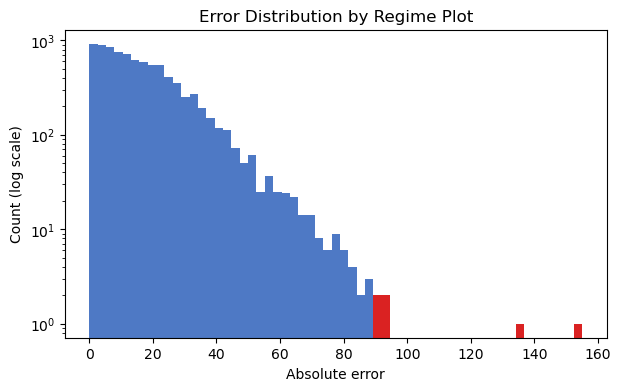

In [30]:
# 절대 오차 값만 추출
err = worst_df["Error"]

# normal 오차 집단 exterme 오차 집단 정의
normal = err[err < 90]
extreme = err[err >= 90]

# 그래프 크기 설정
plt.figure(figsize = (7,4))

# 오차를 60구간으로 나눔
bins = np.linspace(0, err.max(), 60)

# normal 오차 집단 extreme 오차 집단 히스토그램 생성
plt.hist(extreme, bins = bins, color = "#DA2222")
plt.hist(normal, bins = bins, color = "#4E79C5")

# extreme 사건의 개수가 적으므로 로그 스케일로 변환
plt.yscale("log")

# 그래프 라벨 및 제목 설정
plt.xlabel("Absolute error")
plt.ylabel("Count (log scale)")
plt.title("Error Distribution by Regime Plot")
plt.savefig("../04_results/random_forest/fig13.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [31]:
# 절대 오차 값으로 데이터 집단을 나눔
worst_df["Regime"] = "Normal"
worst_df.loc[worst_df["Error"] >= 90, "Regime"] = "Extreme"

# 집단별 데이터 따로 저장
extreme_df = worst_df[worst_df["Regime"] == "Extreme"]
normal_df = worst_df[worst_df["Regime"] == "Normal"]

# Actual, Predicted, Error열 제거
drop_cols = ["Actual", "Predicted", "Error"]
normal_df_clean  = normal_df.drop(columns = drop_cols)
extreme_df_clean = extreme_df.drop(columns = drop_cols)

# Normal 집단과 Exterme 집단의 변수 평균 계산
compare = pd.DataFrame({"Normal_mean": normal_df_clean.mean(numeric_only = True), "Extreme_mean": extreme_df_clean.mean(numeric_only = True)})

# Normal 집단과 Exterme 집단의 변수 평균 차이 계산
compare["Diff"] = compare["Extreme_mean"] - compare["Normal_mean"]

# 정상 집단 대비 극단 집단에서의 상대적 증가율 계산
compare["Increase_%"] = (compare["Diff"] / compare["Normal_mean"]) * 100

# 증가율 기준 내림차순 정렬
compare.sort_values("Increase_%", ascending = False)

,Normal_mean,Extreme_mean,Diff,Increase_%
Area_Other,0.027180,0.166667,0.139487,513.206215
Category_Home,0.059311,0.166667,0.107355,181.003236
Category_Toys,0.062075,0.166667,0.104591,168.491033
Category_Pet Supplies,0.062421,0.166667,0.104246,167.004920
Category_Skincare,0.062766,0.166667,0.103900,165.535168
Category_Snacks,0.066337,0.166667,0.100330,151.244213
Category_Electronics,0.068410,0.166667,0.098257,143.630752
Traffic_score,2.387309,3.166667,0.779358,32.645891
Pickup_Wait_Time,10.022458,10.833333,0.810876,8.090587
Agent_Rating,4.632224,4.600000,-0.032224,-0.695646


In [32]:
# 증가율 기준 내림차순 정렬
plot_df = compare.sort_values("Increase_%", ascending=False)

# 증가율 순위에 따라 변수들을 3구간 색으로 나눔
# Category_Electronics가 있는 위치까지 붉은색 계열의 색 사용
# Area_Metropolitian이 있는 위치까지 회색 계열의 색 사용
# Category_Grocery가 있는 위치까지 푸른색 계열의 색 사용
for i in range(len(plot_df)):
    if i <= plot_df.index.get_loc("Category_Electronics"):
        colors.append("#DA2222") 
    elif i <= plot_df.index.get_loc("Area_Metropolitian"):
        colors.append("#666666")   
    else:
        colors.append("#4E79C5")    

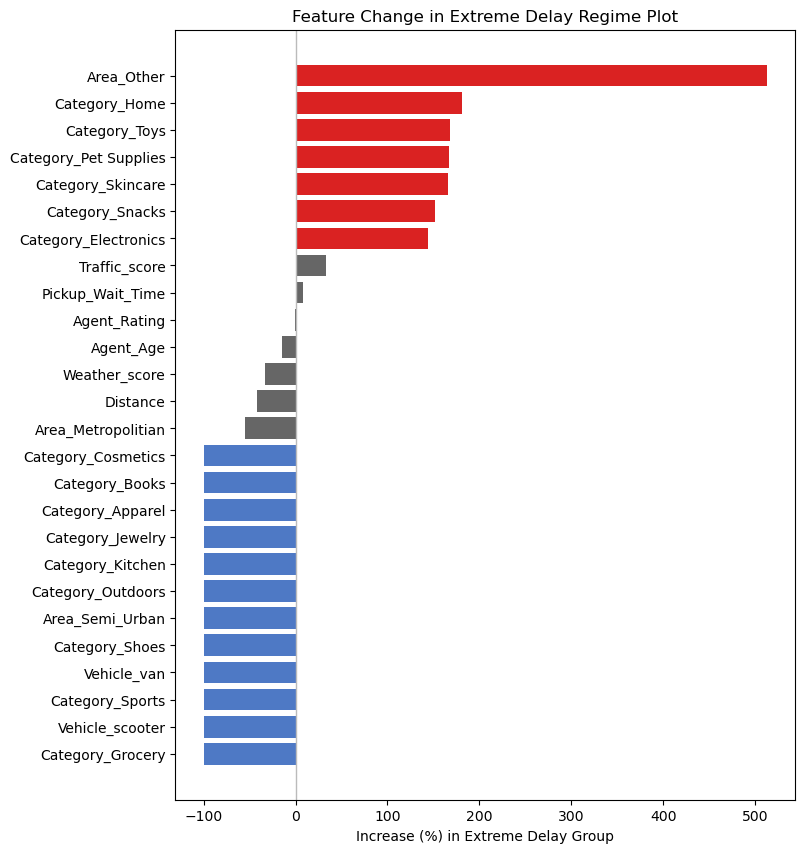

In [33]:
# 그래프 크기 설정
plt.figure(figsize = (8,10))

# 가로 막대 그래프 생성 (x축 = 증가율 값, y축 = 변수 이름, 색 = 위의 셀에서 만든 3구간) ([::-1]은 데이터를 역순으로 뒤집는다는 의미)
plt.barh(plot_df.index[::-1], plot_df["Increase_%"][::-1], color=colors[::-1])

# 기준선 추가
plt.axvline(0, color = "#BBBBBB", linewidth = 1)

# 그래프 라벨 및 제목 설정
plt.title("Feature Change in Extreme Delay Regime Plot")
plt.xlabel("Increase (%) in Extreme Delay Group")
plt.savefig("../04_results/random_forest/fig14.png", dpi = 300, bbox_inches = "tight")
plt.show()